# EDA for DietDupe

### load the data

In [10]:
import pickle
import pandas as pd

# load the data of node embeddings in FlavourGraph
with open('data/FlavorGraph_node_embedding.pickle', 'rb') as f:
    data = pickle.load(f)

# cast node_ids to integer
data = {int(k): v for k, v in data.items()}


In [11]:
# read information abo
nodes= pd.read_csv('data/nodes_191120.csv')

#delete nan in node name column
nodes = nodes.dropna(subset=['name'])

# make sure name is a string
nodes['name'] = nodes['name'].astype(str)

nodes.head()

,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


In [12]:
# merge the dataframe and dictionnary by name and display projection

nodes['embeddings'] = nodes['node_id'].map(data)

In [13]:
nodes.head()

,node_id,name,id,node_type,is_hub,embeddings
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub,"[-0.10600116, 0.047149494, 0.10841199, 0.07235..."
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub,"[-0.015829312, 0.09736368, -0.0006226096, 0.13..."
2,3,10%_cream,NaN,ingredient,no_hub,"[-0.10132008, 0.033723958, 0.064727835, 0.1566..."
3,4,100%_bran,NaN,ingredient,no_hub,"[-0.10309663, 0.03204953, 0.08858223, 0.105722..."
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub,"[-0.09346332, 0.120890595, 0.10606088, 0.10007..."


## Our first extrenal dataset will concern the kcal and nutritional values for foods - for example for the search of a lower calorie alternative of a food, or richer in a certain vitamin group

In [14]:
# calories dataset
nutri_data= pd.read_csv('data/ABBREV.csv')
nutri_data.head()

,index,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,...,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,...,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,...,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0
3,3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,...,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0
4,4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,...,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0


## Preprocessing (expand abbrevs, split words, lemmatization, etc.)

In [15]:
import re
import enchant
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

en_dict = enchant.Dict("en_US")
word_whitelist_regex = re.compile(r"\d+%?")
def is_english_word(s: str) -> bool:
    return en_dict.check(s) or word_whitelist_regex.match(s)

nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Hard-coded, hand-made regex for splitting words
split_regex = re.compile(r"[|,\s()&_]+|w/")

def preprocess(desc: str) -> str:
    tokens = split_regex.split(desc.lower())  # Lower case and split words

    # Remove stuff like "without salt" or "wo/salt" (just don't list salt, low relevance)
    tokens_new = []
    i = 0
    while i < len(tokens):
        if tokens[i] in ("without", "w/o", "wo/"):
            i += 2  # skip the next token
            continue
        if tokens[i].startswith("wo/"):
            i += 1
            continue
        tokens_new.append(tokens[i])
        i += 1
    tokens = tokens_new
    
    # Expand abbreviations
    tokens_new = []
    for token in tokens:
        if token in abbrev_map:
            tokens_new.extend(split_regex.split(abbrev_map[token].lower()))
        else:
            tokens_new.append(token)
    tokens = tokens_new
            
    tokens = filter(len, tokens)                            # Filter out empty words
    tokens = filter(lambda x: x not in stop_words, tokens)  # Remove stop words
    tokens = list(tokens)

    # Save all non-english words and their contexts for later summary
    # (helps for manually extending abbrev_map)
    for token in filter(lambda x: not is_english_word(x), tokens):
        if token not in unknown_abbreviations:
            unknown_abbreviations[token] = set()
        unknown_abbreviations[token].add(desc)
            
    tokens = map(lemmatizer.lemmatize, tokens)  # Apply lemmatization
    tokens = sorted(tokens)                    # Sort final word list
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/pcache/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pcache/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Print unknown abbreviations summary (optional)
def print_unknown_abbreviations(first_n: int = 100) -> None:
    # Sort by the number of contexts in which it they occurred
    unknown_abbrevs_list = list(unknown_abbreviations.items())
    unknown_abbrevs_list.sort(key=lambda x: len(x[1]), reverse=True)
    
    print(f"Unknown abbreviations (total contexts: {sum(len(x[1]) for x in unknown_abbrevs_list)}):")
    for i, (token, context) in enumerate(unknown_abbrevs_list, 1):
        print(f"{i}.  '{token}'  ({len(context)} contexts)")
        for desc in list(context)[:min(10, len(context))]:  # Only show up to 10 contexts for readability
            print("\t", desc)
        if i == first_n:
            break

# WORKFLOW:
# 1. Apply preprocessing
# 2. Print this summary
# 3. Inspect unknown abbreviations, try to decipher some, update abbrev_map.
#    - https://www.allacronyms.com/DRND/food
#    - https://nutritioncalc3.mheducation.com/ncplus3/resources/abbrev.pdf
# 4. Repeat

### nodes

In [17]:
abbrev_map = {}
unknown_abbreviations = {}
nodes["clean_name"] = nodes["name"].apply(preprocess)

In [18]:
print_unknown_abbreviations()

Unknown abbreviations (total contexts: 2762):
1.  'italian'  (64 contexts)
	 italian_plum
	 italian_cheese_blend
	 italian_cut_green_bean
	 frozen_italian_cut_green_bean
	 hot_italian_sausage
	 fresh_italian_parsley
	 italian_sweet_sausage
	 italian_salad_dressing_mix
	 mixed_italian_herb
	 italian_spice
2.  'chile'  (38 contexts)
	 pasilla_chile
	 chile
	 fresno_chile_pepper
	 red_jalapeno_chile
	 hatch_chile
	 dried_arbol_chile
	 dried_chipotle_chile
	 ground_chipotle_chile_pepper
	 canned_chipotle_chile
	 jalapeno_chile
3.  'cooky'  (29 contexts)
	 reduced_fat_oreo_cooky
	 chocolate_chip_cooky
	 wafer_cooky
	 sugar_free_shortbread_cooky
	 vanilla_wafer_cooky
	 shortbread_cooky
	 thin_mint_cooky
	 sugar_cooky
	 peanut_butter_sandwich_cooky
	 oreo_cooky
4.  'chinese'  (24 contexts)
	 chinese_cabbage
	 chinese_noodle
	 chinese_celery
	 dried_chinese_mushroom
	 chinese_wine
	 chinese_eggplant
	 chinese_five_spice_powder
	 chinese_chive
	 chinese_sausage
	 chinese_white_rice_vinegar
5.  

In [19]:
nodes[["name", "clean_name"]]

,name,clean_name
0,1%_fat_buttermilk,1% buttermilk fat
1,1%_fat_cottage_cheese,1% cheese cottage fat
2,10%_cream,10% cream
3,100%_bran,100% bran
4,10_inch_flour_tortilla,10 flour inch tortilla
...,...,...
8293,Procyanidin_B2,b2 procyanidin
8294,Procyanidin_C,c procyanidin
8295,6-Keto-28-homobrassinolide,6-keto-28-homobrassinolide
8296,Anthocyanidins,anthocyanidins


### nutri_data

In [20]:
# Hard-coded, hand-made list of abbreviation expansions for ABBREV.csv
abbrev_map = {
    "w/": "with",
    "lrg": "large",
    "sml": "small",
    "crmd": "creamed",
    "uncrmd": "",
    "lowfat": "low fat",
    "milkfat": "milk fat",
    "ckd": "cooked",
    "cnd": "canned",
    "frz": "frozen",
    "rstd": "roasted",
    "bnless": "boneless",
    "bld": "boiled",
    "frsh": "fresh",
    "ln": "lean",
    "brst": "breast",
    "babyfood": "baby food",
    "choic": "choice",
    "whl": "whole",
    "h2o": "water",
    "drnd": "drained",
    "skn": "skin",
    "brsd": "braised",
    "pan-fried": "fried",
    "chs": "chips",
    "grds": "grades",
    "stmd": "steamed",
    "unprep": "unprepared",
    "rnd": "round",
    "nz": "",  # stands for New Zealand as far as I can tell; not relevant?
    "brld": "broiled",
    "juc": "juice",
    "sel": "select",  # not very sure, but it seems plausible (https://www.usda.gov/media/blog/2013/01/28/whats-your-beef-prime-choice-or-select)
    "shldr": "shoulder",
    "crm": "cream",
    "stk": "steak",
    "pln": "plain",
    "cond": "condensed",
    "sau": "sauce",
    "bev": "beverage",
    "condmnt": "condiment",
    "soybn": "soybean",
    "rst": "roast",
}

unknown_abbreviations = {}
nutri_data["Clean_Desc"] = nutri_data["Shrt_Desc"].apply(preprocess)

In [21]:
print_unknown_abbreviations()

Unknown abbreviations (total contexts: 10439):
1.  'campbell's'  (171 contexts)
	 CAMPBELL'S,98% FAT FREE CRM OF CHICK SOUP,COND
	 CAMPBELL'S HOMESTYLE MEXICAN STYLE CHICK TORTILLA SOUP
	 CAMPBELL'S SOUP ON THE GO,VEG BF SOUP
	 CAMPBELL'S,SPAGHETTIOS,W/ MEATBALLS -
	 CAMPBELL'S RED & WHITE,DOUBLE NOODLE IN CHICK BROTH SOP,COND
	 CAMPBELL'S HOMESTYLE MICROWAVEABLE BOWLS,HEALTHY REQUEST MEX
	 CAMPBELL'S CHUNKY SOUPS,OLD FASHIONED VEG BF SOUP
	 CAMPBELL'S CHUNKY SOUPS,SAVORY POT RST SOUP
	 CAMPBELL'S,CRM OF MUSHROOM W/ RSTD GARLIC SOUP,COND
	 CAMPBELL'S,RED & WHITE,CHICK NOODLE SOUP,COND
2.  'kellogg's'  (150 contexts)
	 KELLOGG'S,EGGO,MINI MUFFIN TOPS,BLUEBERRY
	 KELLOGG'S,POP-TARTS,FRSTD PUMPKIN PIE TOASTER PASTRIES
	 TOASTER PASTRIES,KELLOGG,KELLOGG'S POP TARTS,FRSTD BLUEBERRY
	 CEREALS RTE,KELLOGG,KELLOGG'S SMART START ANTIOXIDANTS CRL
	 CEREALS RTE,KELLOGG,KELLOGG'S,RAISIN BRAN CRUNCH
	 CEREALS RTE,KELLOGG'S KRAVE SMORES
	 CEREALS RTE,KELLOGG'S,SPL K PROT,CINN BROWN SUGAR CRUNCH
	 KE

In [22]:
nutri_data[["Shrt_Desc", "Clean_Desc"]]

,Shrt_Desc,Clean_Desc
0,"BUTTER,WITH SALT",butter salt
1,"BUTTER,WHIPPED,W/ SALT",butter salt whipped
2,"BUTTER OIL,ANHYDROUS",anhydrous butter oil
3,"CHEESE,BLUE",blue cheese
4,"CHEESE,BRICK",brick cheese
...,...,...
8785,"MACKEREL,SALTED",mackerel salted
8786,"SCALLOP,(BAY&SEA),CKD,STMD",bay cooked scallop sea steamed
8787,"SYRUP,CANE",cane syrup
8788,"SNAIL,RAW",raw snail


## Preliminarly match the data

In [14]:
# embed the strings
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


/home/pcache/.local/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
embedded_names = []
for i, name in enumerate(nodes["clean_name"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    inputs = tokenizer(name.replace("_", " "), return_tensors='pt')
    outputs = model(**inputs)
    embedded_names.append(outputs[0].detach().numpy().squeeze().mean(axis=0))


Processing 0 : 1% buttermilk fat
Processing 500 : bleached flour purpose
Processing 1000 : bag chamomile tea
Processing 1500 : corn
Processing 2000 : dry pasta penne
Processing 2500 : brown frozen hash onion pepper
Processing 3000 : extract hazelnut
Processing 3500 : concentrate juice lemon
Processing 4000 : green mixed salad
Processing 4500 : dough made pie pillsbury ready
Processing 5000 : butter creamy fat peanut reduced
Processing 5500 : link sausage smoked
Processing 6000 : maria tia
Processing 6500 : cumin seed whole
Processing 7000 : cis-3-hexenyl pentanoate
Processing 7500 : citronellyl propionate
Processing 8000 : 3 4-hexanedione


In [16]:
embedded_external_data = []
for i, name in enumerate(nutri_data["Clean_Desc"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    inputs = tokenizer(name.lower().replace(",", " "), return_tensors='pt')
    outputs = model(**inputs)
    embedded_external_data.append(outputs[0].detach().numpy().squeeze().mean(axis=0))

Processing 0 : butter salt
Processing 500 : baby food rice todd turkey veg
Processing 1000 : cooked meat neck simmrd turkey whole
Processing 1500 : - bowl campbell's microwaveable red soup tomato white
Processing 2000 : bar crl rice wheat
Processing 2500 : broiled cooked fat fresh lean loin pork whole
Processing 3000 : co lettuce raw romaine
Processing 3500 : boiled cooked drained salt turnip
Processing 4000 : 1/8"fat 6-9 beef cooked end fat large lean prime rib rib roasted
Processing 4500 : cod fish frozen may pacific previously raw
Processing 5000 : oil-roasted peanut virginia
Processing 5500 : braised cooked fat hind-shank imp lamb lean
Processing 6000 : corn shell tostada
Processing 6500 : cooked millet
Processing 7000 : crispy mcdonald's ranch snack wrap
Processing 7500 : beef cooked fast fried imp knuckle
Processing 8000 : cocadas cocnt cooky mother's
Processing 8500 : carrabba's grill italian pomodoro sauce spaghetti


### Match the data using BERT model and compute similarity scores

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'embedded_names' and 'external_data_embed' are your lists of BERT embeddings
embedded_names_np = np.array(embedded_names)
external_data_embed_np = np.array(embedded_external_data)

# Compute the cosine similarity between all pairs of vectors
similarity_matrix = cosine_similarity(embedded_names_np, external_data_embed_np)

# Find the index of the most similar vector for each vector in 'embedded_names'
most_similar_indices = np.argmax(similarity_matrix, axis=1)
most_similar_values = np.max(similarity_matrix, axis=1)

# Create a list of tuples where each tuple is a pair of indices of the most similar embeddings
most_similar = list(zip(range(len(embedded_names)), most_similar_indices, most_similar_values))

In [18]:
#append the embedding and name froom extrernal data to nodes dataframe
nodes['best_match'] = None
nodes['similarity_of_best_match'] = None
# map nodes
for i, j, sim in most_similar:
    nodes.loc[i, 'best_match'] = nutri_data.loc[j, 'Clean_Desc']
    nodes.loc[i, 'similarity_of_best_match'] = sim

In [19]:
nodes.head(20)

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match
0,0.0,1%_fat_buttermilk,NaN,ingredient,no_hub,"[-0.10600116, 0.047149494, 0.10841199, 0.07235...",1% buttermilk fat,buttermilk dried milk,0.843161
1,1.0,1%_fat_cottage_cheese,NaN,ingredient,no_hub,"[-0.015829312, 0.09736368, -0.0006226096, 0.13...",1% cheese cottage fat,1% cheese cottage fat fat low milk,0.888553
2,3.0,10%_cream,NaN,ingredient,no_hub,"[-0.10132008, 0.033723958, 0.064727835, 0.1566...",10% cream,butter,0.767033
3,4.0,100%_bran,NaN,ingredient,no_hub,"[-0.10309663, 0.03204953, 0.08858223, 0.105722...",100% bran,butter,0.757565
4,5.0,10_inch_flour_tortilla,NaN,ingredient,no_hub,"[-0.09346332, 0.120890595, 0.10606088, 0.10007...",10 flour inch tortilla,chip plain salted tortilla yellow,0.853975
5,7.0,12_inch_pizza_crust,NaN,ingredient,no_hub,"[0.019675368, 0.0335593, -0.05435514, 0.112564...",12 crust inch pizza,"12"" chip crust hut pan pizza pizza",0.835156
6,9.0,18%_table_cream,NaN,ingredient,no_hub,"[-0.17582406, 0.14053129, -0.022183008, 0.0534...",18% cream table,beet canned harvard liquid sol,0.808048
7,10.0,2%_buttermilk,NaN,ingredient,no_hub,"[-0.07227368, 0.033502933, 0.037231416, 0.1503...",2% buttermilk,buttermilk dried milk,0.878782
8,11.0,2%_cheddar_cheese,NaN,ingredient,no_hub,"[0.12324965, -0.26437616, -0.09264475, 0.06749...",2% cheddar cheese,cheddar cheese,0.89535
9,12.0,2%_evaporated_milk,NaN,ingredient,no_hub,"[-0.23566853, -0.048889615, 0.09088527, 0.1119...",2% evaporated milk,blend filled fluid hydr milk oil veg,0.755557


In [23]:
# save matched nodes
#nodes.to_csv('data/nodes_191120_matched.csv', index=False)
nodes = pd.read_csv('data/nodes_191120_matched.csv')

In [24]:
nodes.head()

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match
0,0.0,1%_fat_buttermilk,NaN,ingredient,no_hub,[-1.06001161e-01 4.71494943e-02 1.08411990e-...,1% buttermilk fat,buttermilk dried milk,0.843161
1,1.0,1%_fat_cottage_cheese,NaN,ingredient,no_hub,[-1.58293117e-02 9.73636806e-02 -6.22609572e-...,1% cheese cottage fat,1% cheese cottage fat fat low milk,0.888553
2,3.0,10%_cream,NaN,ingredient,no_hub,[-1.01320080e-01 3.37239578e-02 6.47278354e-...,10% cream,butter,0.767033
3,4.0,100%_bran,NaN,ingredient,no_hub,[-0.10309663 0.03204953 0.08858223 0.105722...,100% bran,butter,0.757565
4,5.0,10_inch_flour_tortilla,NaN,ingredient,no_hub,[-9.34633166e-02 1.20890595e-01 1.06060877e-...,10 flour inch tortilla,chip plain salted tortilla yellow,0.853975


# Matching using Food2Vec

In [22]:
! pip install food2vec

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


In [25]:
from food2vec.semantic_nutrition import Estimator

estimator = Estimator() 

embedded_names_food2vec = []
for i, name in enumerate(nodes["clean_name"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    try:
        embedded_names_food2vec.append(estimator.embed(name.replace("_", " ")))
    except:
        print(f"Error processing {i} : {name} - no such name in food2vec")
        embedded_names_food2vec.append(None)
    

/home/pcache/.local/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


------ALERT--------
You're using demonstration nutrition data. This is a random subset (~100 items) from our annotated database.
We do not have permission to distribute our full dataset, and we recommend processing your own.
The USDA provides an excellent start: https://fdc.nal.usda.gov/
You can suppress this warning by setting the 'demo_warning' parameter to False.
-------------------
Processing 0 : 1% buttermilk fat
Error processing 33 : abalone - no such name in food2vec
Error processing 34 : absinthe - no such name in food2vec
Error processing 36 : achiote - no such name in food2vec
Error processing 44 : active starter - no such name in food2vec
Error processing 47 : advocaat - no such name in food2vec
Error processing 49 : agar - no such name in food2vec
Error processing 50 : agar agar - no such name in food2vec
Error processing 60 : ajinomoto - no such name in food2vec
Error processing 61 : ajwain - no such name in food2vec
Error processing 64 : alcaparrado - no such name in food

In [26]:
embedded_external_data_food2vec = []
for i, name in enumerate(nutri_data["Clean_Desc"]):
    if i%500 == 0:
        print(f"Processing {i} : {name}")
    new_name = name.lower().replace(",", " ")
    try:
        embedded_external_data_food2vec.append(estimator.embed(new_name))
    except:
        print(f"Error processing {i} : {new_name} - no such name in food2vec")
        embedded_external_data_food2vec.append(None)
    

Processing 0 : butter salt
Error processing 468 : zwieback - no such name in food2vec
Processing 500 : baby food rice todd turkey veg
Error processing 525 : ara dha enfamillipil formula inf irn johnson mead pdr - no such name in food2vec
Error processing 543 : ara dha enfamil formula inf johnson lipil mead rtf - no such name in food2vec
Error processing 544 : 60/40 abbott formula inf nutr pdr pm recon similac - no such name in food2vec
Error processing 545 : ara dha enf inf iro joh lipil nutr pdr - no such name in food2vec
Error processing 551 : ara co dha enf fo inf ir jo lipil liq nutr - no such name in food2vec
Error processing 557 : ara dha en formula inf iro joh lipi mea pd pr - no such name in food2vec
Error processing 565 : abbott child formerly formula nutr pediasure ross rtf - no such name in food2vec
Error processing 567 : ara dha feed form inf jo lipil next proso reato step - no such name in food2vec
Error processing 569 : enfamil formula inf johnson lactofree mead rtf - no 

In [27]:
import numpy as np

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'embedded_names' and 'external_data_embed' are your lists of BERT embeddings
embedded_names_np = np.array([embedded_name if embedded_name is not None else np.zeros(300) for embedded_name in embedded_names_food2vec ])
external_data_embed_np = np.array([embedded_name if embedded_name is not None else np.zeros(300) for embedded_name in embedded_external_data_food2vec])

# Compute the cosine similarity between all pairs of vectors
similarity_matrix = cosine_similarity(embedded_names_np, external_data_embed_np)

# Find the index of the most similar vector for each vector in 'embedded_names'
most_similar_indices = np.argmax(similarity_matrix, axis=1)
most_similar_values = np.max(similarity_matrix, axis=1)

# Create a list of tuples where each tuple is a pair of indices of the most similar embeddings
most_similar_food2vec = list(zip(range(len(embedded_names_food2vec)), most_similar_indices, most_similar_values))

In [29]:
nodes_f2v = nodes.copy()

In [30]:
#append the embedding and name froom extrernal data to nodes dataframe
nodes_f2v['best_match'] = None
nodes_f2v['similarity_of_best_match'] = None
# map nodes
for i, j, sim in most_similar_food2vec:
    nodes_f2v.loc[i, 'best_match'] = nutri_data.loc[j, 'Clean_Desc']
    nodes_f2v.loc[i, 'similarity_of_best_match'] = sim

In [31]:
nodes_f2v.head(20)

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match
0,0.0,1%_fat_buttermilk,NaN,ingredient,no_hub,[-1.06001161e-01 4.71494943e-02 1.08411990e-...,1% buttermilk fat,1% fat fluid milk vit vit,0.796985
1,1.0,1%_fat_cottage_cheese,NaN,ingredient,no_hub,[-1.58293117e-02 9.73636806e-02 -6.22609572e-...,1% cheese cottage fat,2% cheese cottage fat fat low milk,0.906083
2,3.0,10%_cream,NaN,ingredient,no_hub,[-1.01320080e-01 3.37239578e-02 6.47278354e-...,10% cream,coffee cream cream cream fluid lt table,0.922297
3,4.0,100%_bran,NaN,ingredient,no_hub,[-0.10309663 0.03204953 0.08858223 0.105722...,100% bran,bran corn crude,0.859974
4,5.0,10_inch_flour_tortilla,NaN,ingredient,no_hub,[-9.34633166e-02 1.20890595e-01 1.06060877e-...,10 flour inch tortilla,-fry flr refr rtb tortilla,0.821928
5,7.0,12_inch_pizza_crust,NaN,ingredient,no_hub,[ 1.96753684e-02 3.35593000e-02 -5.43551408e-...,12 crust inch pizza,"14"" crust john's original papa pepperoni pizza",0.854801
6,9.0,18%_table_cream,NaN,ingredient,no_hub,[-0.17582406 0.14053129 -0.02218301 0.053433...,18% cream table,coffee cream cream cream fluid lt table,0.901807
7,10.0,2%_buttermilk,NaN,ingredient,no_hub,[-0.07227368 0.03350293 0.03723142 0.150398...,2% buttermilk,buttermilk dried milk,0.833767
8,11.0,2%_cheddar_cheese,NaN,ingredient,no_hub,[ 0.12324965 -0.26437616 -0.09264475 0.067499...,2% cheddar cheese,cheddar cheese,1.0
9,12.0,2%_evaporated_milk,NaN,ingredient,no_hub,[-0.23566853 -0.04888961 0.09088527 0.111990...,2% evaporated milk,fluid human mature milk,0.745948


In [32]:
# fill nodes from food2vec with nodes from bert
nodes_f2v.loc[nodes_f2v['similarity_of_best_match'] == 0.0, 'best_match'] = nodes['best_match']
nodes_f2v['bert_embeddings_similarity'] = nodes['similarity_of_best_match']
nodes_f2v['similarity_of_best_match_joint'] = np.maximum(nodes_f2v['similarity_of_best_match'].fillna(0), nodes_f2v['bert_embeddings_similarity'].fillna(0))


In [31]:
nodes_f2v[nodes_f2v['similarity_of_best_match'] == 0.0].head(30)

,node_id,name,id,node_type,is_hub,embeddings,clean_name,best_match,similarity_of_best_match,bert_embeddings_similarity,similarity_of_best_match_joint
33,38.0,abalone,NaN,ingredient,hub,"[0.21432944, -0.24550392, -0.14755642, 0.24025...",abalone,brick cheese,0.0,0.80537,0.805370
34,39.0,absinthe,NaN,ingredient,no_hub,"[-0.1563259, -0.12958135, -0.105907924, 0.1457...",absinthe,cardamom spice,0.0,0.731808,0.731808
36,44.0,achiote,NaN,ingredient,no_hub,"[-0.20564497, 0.0021581268, -0.017484589, 0.15...",achiote,natto,0.0,0.75963,0.759630
44,53.0,active_starter,NaN,ingredient,no_hub,"[-0.18706283, 0.15871908, 0.01949941, 0.125311...",active starter,raw spot,0.0,0.671306,0.671306
47,56.0,advocaat,NaN,ingredient,no_hub,"[0.06339699, -0.13852063, -0.029949985, 0.0742...",advocaat,celtuce raw,0.0,0.667664,0.667664
49,58.0,agar,NaN,ingredient,hub,"[0.091211654, -0.20150454, -0.26364943, 0.0497...",agar,almond,0.0,0.783143,0.783143
50,59.0,agar_agar,NaN,ingredient,no_hub,"[-0.02377455, -0.032742925, -0.016038483, 0.01...",agar agar,arugula raw,0.0,0.671196,0.671196
60,69.0,ajinomoto,NaN,ingredient,no_hub,"[-0.10433134, 0.021288093, 0.22506452, 0.17667...",ajinomoto,okara,0.0,0.696733,0.696733
61,70.0,ajwain,NaN,ingredient,no_hub,"[-0.19063282, -0.05176021, 0.048555177, 0.1778...",ajwain,date deglet noor,0.0,0.788993,0.788993
64,73.0,alcaparrado,NaN,ingredient,no_hub,"[-0.1326251, 0.040735394, -0.09200989, -0.0749...",alcaparrado,de dulce leche,0.0,0.777173,0.777173


TypeError: '<=' not supported between instances of 'float' and 'NoneType'

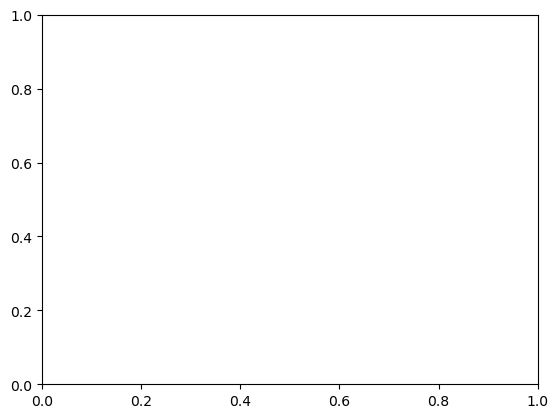

In [32]:
# distribution of similarity scores
import matplotlib.pyplot as plt
plt.hist(nodes['similarity_of_best_match'], bins=10, edgecolor='black')
plt.title('Histogram of Similarity with BERT matchings')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# distribution of similarity scores
import matplotlib.pyplot as plt
plt.hist(nodes_f2v['similarity_of_best_match'].fillna(0), bins=10, edgecolor='black')
plt.title('Histogram of Similarity with Food2Vec matchings')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# distribution of similarity scores from joint data
import matplotlib.pyplot as plt
plt.hist(nodes_f2v['similarity_of_best_match_joint'].fillna(0), bins=10, edgecolor='black')
plt.title('Histogram of Similarity with Food2Vec and BERT matchings')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

## Exploration of the external data

In [ ]:
# get list of columns ending with 'mg'
micro_columns_list = [element for element in nutri_data.columns if element.endswith('mg)')]

# get dataframe with subset of columns for micronutrients
df_micro = nutri_data[micro_columns_list]

# get summary statistics of micronutrient columns
pd.DataFrame(
	data={
		'average':df_micro.mean(),
		'standard_deviation':df_micro.std()
		}
)